# DuraMAT Workshop Live Demo - Geospatial analysis

![PVDeg Logo](../PVD_logo.png)


**Steps:**
1. Initialize weather data into xarray
2. Calculate installation standoff for New Mexico
3. Plot results

**Xarray: multi-dimensional data frame**

![Xarray](./images/xarray.webp)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pvdeg
import dask.array as da
import dask.dataframe as dd
import xarray as xr

In [2]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pvdeg version ", pvdeg.__version__)

Working on a  Linux 4.18.0-477.10.1.el8_8.x86_64
Python version  3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]
Pandas version  2.2.1
pvdeg version  0.2.4.dev77+g3683457


## 1 Start distributed compute cluster - DASK

In [6]:
#Single location

API_KEY = 'UCaEeYw0eAQEYDRq8S0LIQTFlwznp9AwBqTaLOXH'
# The example API key here is for demonstation and is rate-limited per IP.
# To get your own API key, visit https://developer.nrel.gov/signup/

weather_db = 'PSM3'
weather_id = (39.741931, -105.169891)
weather_arg = {'api_key': API_KEY,
               'email': 'user@mail.com',
               'names': 'tmy',
               'attributes': [],
               'map_variables': True}

weather_df, meta = pvdeg.weather.get(weather_db, weather_id, **weather_arg)


k_h = pvdeg.degradation.hydrolysis_driven_rate(weather_df, meta)
print(k_h)

Column "relative_humidity" not found in DataFrame. Calculating...
The array tilt angle was not provided, therefore the latitude tilt of 39.7 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
       k_h
0  0.01449


In [7]:
pvdeg.geospatial.start_dask();

Dashboard: http://127.0.0.1:8787/status


In [9]:
# Get weather data
weather_db = 'NSRDB'

weather_arg = {'satellite': 'Americas',
               'names': 2022,
               'NREL_HPC': True,
               'attributes': ['air_temperature', 'wind_speed', 'dhi', 'ghi', 'dni', 'relative_humidity']}

weather_ds, meta_df = pvdeg.weather.get(weather_db, geospatial=True, **weather_arg)

/home/mspringe/.conda-envs/pvdeg_311/lib/python3.11/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [11]:
meta_CO = meta_df[meta_df['state'] == 'Colorado']
meta_CO_sub, gids_CO_sub = pvdeg.utilities.gid_downsampling(meta_CO, 4)
weather_CO_sub = weather_ds.sel(gid=meta_CO_sub.index)

In [14]:
geo = {'func': pvdeg.degradation.hydrolysis_driven_rate,
       'weather_ds': weather_CO_sub,
       'meta_df': meta_CO_sub}

hydrolysis_res = pvdeg.geospatial.analysis(**geo)

The array tilt angle was not provided, therefore the latitude tilt of 38.3 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 40.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 40.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 40.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 40.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 40.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

In [15]:
hydrolysis_res

<xarray.Dataset> Size: 2kB
Dimensions:    (latitude: 13, longitude: 22)
Coordinates:
  * latitude   (latitude) float32 52B 37.01 37.33 37.65 ... 40.21 40.53 40.85
  * longitude  (longitude) float32 88B -109.1 -108.7 -108.4 ... -102.7 -102.3
Data variables:
    k_h        (latitude, longitude) float64 2kB nan 0.0208 ... 0.01774 0.01832

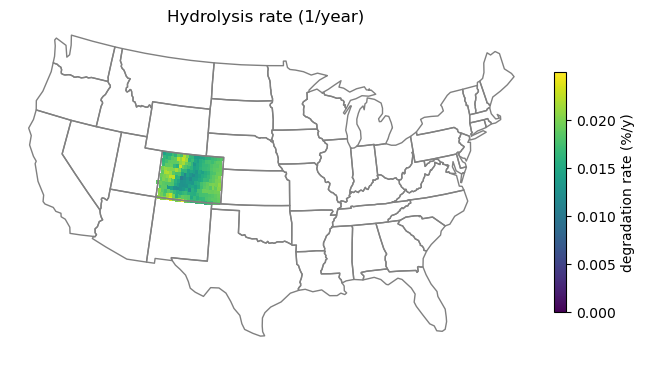

In [17]:
fig, ax = pvdeg.geospatial.plot_USA(hydrolysis_res['k_h'],
                   cmap='viridis', vmin=0, vmax=None,
                   title='Hydrolysis driven degradation rate (1/year)',
                   cb_title='degradation rate (%/y)')